### Data Sources
https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64#wb-auto-6


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class VehicleInfoMappingModel:
    def __init__(self, mint_data_path, fuel_data_paths, bev_data_path, phev_data_path):
        # Load mint dataset
        self.mint_data = pd.read_csv(mint_data_path)

        # Load other relevant datasets
        self.fuel_data = pd.concat([pd.read_csv(path, encoding='latin1') for path in fuel_data_paths], ignore_index=True)
        self.bev_data = pd.read_csv(bev_data_path, encoding='latin1')
        self.phev_data = pd.read_csv(phev_data_path, encoding='latin1')

        # Preprocess data
        self.preprocess_data()

        # Calculate average emission once
        #self.average_emission = self.calculate_average_emission()
        #self.average_emission = 149.73

    def preprocess_data(self):
        # Standardize column names
        def unify_column_names(df):
            df.columns = [col.strip().replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]
            return df

        self.fuel_data = unify_column_names(self.fuel_data)
        self.bev_data = unify_column_names(self.bev_data)
        self.phev_data = unify_column_names(self.phev_data)

        # Select features and fill missing values
        def select_and_fill_features(df, required_features, vehicle_type):
            df = df.loc[:, required_features]
            df = df.fillna(0)
            df['Vehicle_type'] = vehicle_type
            return df

        required_features = ['Make', 'Model', 'Model_year', 'CO2_emissions_g/km']

        self.fuel_data_cleaned = select_and_fill_features(self.fuel_data, required_features, 'ICEV')
        self.bev_data_cleaned = select_and_fill_features(self.bev_data, required_features, 'BEV')
        self.phev_data_cleaned = select_and_fill_features(self.phev_data, required_features, 'PHEV')

        # Combine all datasets
        self.all_data_cleaned = pd.concat([self.fuel_data_cleaned, self.bev_data_cleaned, self.phev_data_cleaned], ignore_index=True)

    def get_vehicle_info(self, token_id):
        vehicle_info = self.mint_data[self.mint_data['tokenId'] == token_id]
        if vehicle_info.empty:
            return "Vehicle not found in mint data."
        
        vehicle_info = vehicle_info.iloc[0]
        make = vehicle_info['make']
        model_name = vehicle_info['model']
        year = vehicle_info['year']
        owner = vehicle_info['owner']
        
        return make, model_name, year, owner

    def grade_emission(self, emission):
        """
        Grade the vehicle based on CO2 emissions.
        A: SULEV and zero emission vehicles (emissions < 10% of average)
        B: ULEV (emissions < 50% of average)
        C: Low emission vehicles (emissions < average)
        D: High emission vehicles (emissions >= average)
        """
        average_emission = 250  # Average emissions for 2024 in g/km
        if emission == 0:
            return 'A', 'Electric Vehicle'
        elif emission < average_emission * 0.1:
            return 'A', 'Super Ultra Low Emission Vehicle'
        elif emission < average_emission * 0.5:
            return 'B', 'Ultra Low Emission Vehicle'
        elif emission < average_emission:
            return 'C', 'Low Emission Vehicle'
        else:
            return 'D', 'High Emission Vehicle'

    def map_emissions(self, token_id):
        vehicle_info = self.get_vehicle_info(token_id)
        if isinstance(vehicle_info, str):
            return vehicle_info
        
        make, model_name, year, owner = vehicle_info
        emissions = self.get_emissions_from_training_data(make, model_name, year, self.all_data_cleaned)
        grade, type_ = self.grade_emission(emissions)
        return {
            'Owner': owner,
            'Make': make,
            'Model': model_name,
            'Year': year,
            'CO2 Emissions (g/km)': round(emissions, 2),
            'Type': type_,
            'Grade': grade
        }

    def get_emissions_from_training_data(self, make, model, year, training_data):
        # Find exact matching vehicle
        matching_vehicle = training_data[
            (training_data['Make'] == make) & 
            (training_data['Model'] == model) & 
            (training_data['Model_year'] == year)
        ]
        
        # If no exact match, find partial matches
        if matching_vehicle.empty:
            partial_matching_vehicle = training_data[
                (training_data['Make'] == make) & 
                (training_data['Model_year'] == year) & 
                (training_data['Model'].str.contains(model, case=False, regex=False))
            ]
            if partial_matching_vehicle.empty:
                return "Emissions data not found for this vehicle."
            else:
                return partial_matching_vehicle['CO2_emissions_g/km'].median()  # Use median instead of mean
        else:
            return matching_vehicle['CO2_emissions_g/km'].median()  # Use median instead of mean

    def visualize_emissions(self, make, model, year, specific_emission):
        fig, axes = plt.subplots(3, 1, figsize=(18, 24))

        # Average emissions for the same model
        model_emissions = self.all_data_cleaned[self.all_data_cleaned['Model'].str.contains(model, case=False)]['CO2_emissions_g/km']
        model_avg_emission = model_emissions.mean()
        axes[0].bar([str(model), 'Model Average'], [specific_emission, model_avg_emission], color=['red', 'blue'])
        axes[0].set_title(f'{model} Model CO2 Emissions Comparison', fontsize=18)
        axes[0].set_ylabel('CO2 Emissions (g/km)', fontsize=16)
        axes[0].tick_params(axis='x', labelsize=14)
        axes[0].tick_params(axis='y', labelsize=14)

        # Average emissions for the same year
        year_emissions = self.all_data_cleaned[self.all_data_cleaned['Model_year'] == year]['CO2_emissions_g/km']
        year_avg_emission = year_emissions.mean()
        axes[1].bar([str(model), 'Year Average'], [specific_emission, year_avg_emission], color=['red', 'blue'])
        axes[1].set_title(f'{year} Year CO2 Emissions Comparison', fontsize=18)
        axes[1].set_ylabel('CO2 Emissions (g/km)', fontsize=16)
        axes[1].tick_params(axis='x', labelsize=14)
        axes[1].tick_params(axis='y', labelsize=14)

        # Average emissions for the same make
        make_emissions = self.all_data_cleaned[self.all_data_cleaned['Make'] == make]['CO2_emissions_g/km']
        make_avg_emission = make_emissions.mean()
        axes[2].bar([str(model), 'Make Average'], [specific_emission, make_avg_emission], color=['red', 'blue'])
        axes[2].set_title(f'{make} Make CO2 Emissions Comparison', fontsize=18)
        axes[2].set_ylabel('CO2 Emissions (g/km)', fontsize=16)
        axes[2].tick_params(axis='x', labelsize=14)
        axes[2].tick_params(axis='y', labelsize=14)

        # Add legend
        legend_patches = [plt.Line2D([0], [0], color='red', lw=4, label=f'{model} Emissions'),
                          plt.Line2D([0], [0], color='blue', lw=4, label='Average Emissions')]
        for ax in axes:
            ax.legend(handles=legend_patches, loc='upper right', fontsize=14)

        plt.tight_layout()
        plt.show()
    
    def calculate_average_emission(self):
        """
        Calculate the average CO2 emissions for vehicles in the mint dataset
        based on the training data.

        Returns:
        - The average CO2 emissions (g/km).
        """
        total_emission = 0
        count = 0

        for index, row in self.mint_data.iterrows():
            make = row['make']
            model = row['model']
            year = row['year']

            matching_vehicle = self.all_data_cleaned[
                (self.all_data_cleaned['Make'] == make) & 
                (self.all_data_cleaned['Model'] == model) & 
                (self.all_data_cleaned['Model_year'] == year)
            ]

            if matching_vehicle.empty:
                partial_matching_vehicle = self.all_data_cleaned[
                    (self.all_data_cleaned['Make'] == make) & 
                    (self.all_data_cleaned['Model_year'] == year) & 
                    (self.all_data_cleaned['Model'].str.contains(model, case=False, regex=False))
                ]
                if not partial_matching_vehicle.empty:
                    total_emission += partial_matching_vehicle['CO2_emissions_g/km'].median()
                    count += 1
            else:
                total_emission += matching_vehicle['CO2_emissions_g/km'].median()
                count += 1

        average_emission = total_emission / count if count != 0 else 0
        return average_emission

    def calculate_co2_assumption1(self, vehicle_count, km_per_day):
        """
        Estimate CO2 emissions based on the number of vehicles and the kilometers they run per day.

        Args:
        - vehicle_count: Number of vehicles.
        - km_per_day: Kilometers each vehicle runs per day.
        - avg_emission: Average CO2 emissions in g/km.

        Returns:
        - Estimated total CO2 emissions per day in grams.
        """
        avg_emission = 149.73
        return vehicle_count * km_per_day * avg_emission

    def calculate_co2_assumption2(self, make, vehicle_count, km_per_day):
        """
        Estimate CO2 emissions based on the car brand, number of vehicles, and the kilometers they run per day.

        Args:
        - make: Car brand.
        - vehicle_count: Number of vehicles.
        - km_per_day: Kilometers each vehicle runs per day.

        Returns:
        - Estimated total CO2 emissions per day in grams for the specified car brand.
        """
        brand_emissions = self.all_data_cleaned[self.all_data_cleaned['Make'] == make]['CO2_emissions_g/km']
        avg_emission = brand_emissions.median() if not brand_emissions.empty else 0
        return vehicle_count * km_per_day * avg_emission


{'Owner': '0x0d4adbb27ccdd2c13f8c9704c156fc9a7cfda05c', 'Make': 'Volvo', 'Model': 'XC40', 'Year': 2021, 'CO2 Emissions (g/km)': 217.0, 'Type': 'Low Emission Vehicle', 'Grade': 'C'}


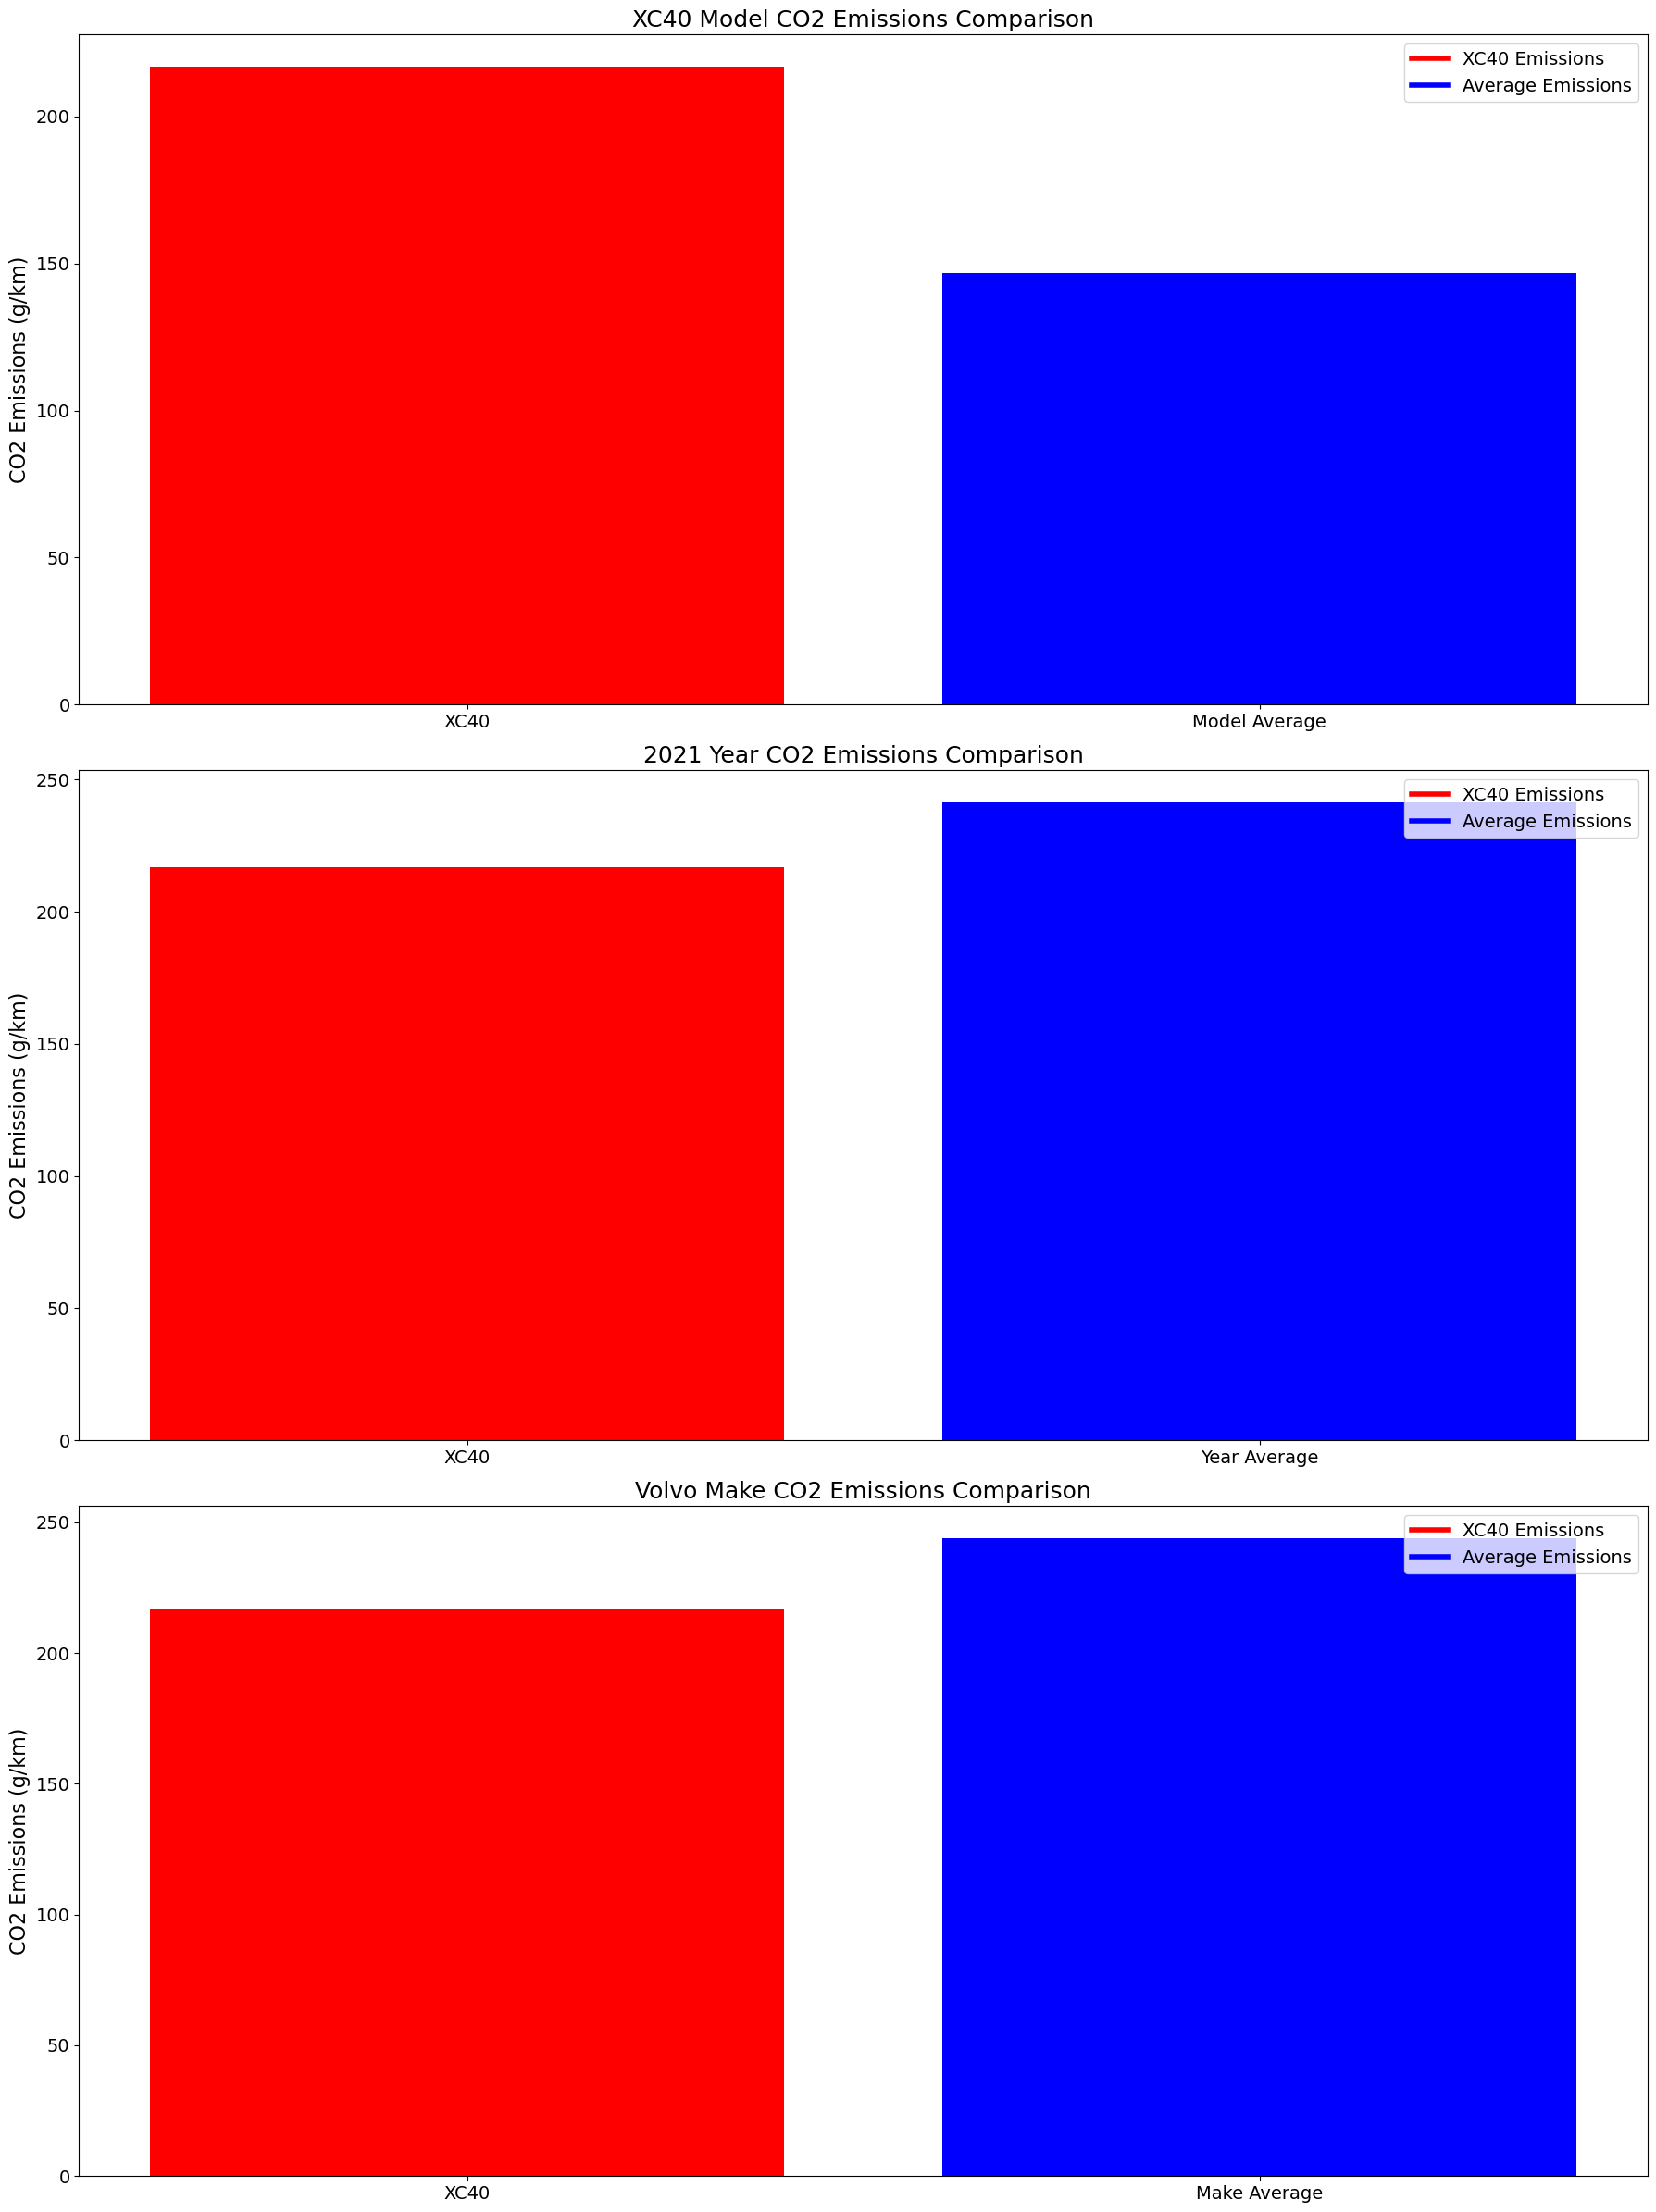

In [10]:
# Data paths
mint_data_path = 'vehicle_mint_data.csv'
fuel_data_paths = [
    'my1995-2004-fuel-consumption-ratings-5-cycle.csv',
    'my2005-2014-fuel-consumption-ratings-5-cycle.csv',
    'my2015-2019-fuel-consumption-ratings.csv',
    'my2020-fuel-consumption-ratings.csv',
    'my2021-fuel-consumption-ratings.csv',
    'my2022-fuel-consumption-ratings.csv',
    'my2023-fuel-consumption-ratings.csv',
    'my2024-fuel-consumption-ratings.csv'
]
bev_data_path = '2012_2024_battery_electric_vehicles.csv'
phev_data_path = '2012_2024_plug_in_hybrid_electric_vehicles.csv'

# Create mapping model instance
mapping_model = VehicleInfoMappingModel(mint_data_path, fuel_data_paths, bev_data_path, phev_data_path)

# User input tokenId for query
token_id = 13500  # Example tokenId
vehicle_info = mapping_model.map_emissions(token_id)
print(vehicle_info)

# Visualize emissions data
if isinstance(vehicle_info, dict):
    mapping_model.visualize_emissions(vehicle_info['Make'], vehicle_info['Model'], vehicle_info['Year'], vehicle_info['CO2 Emissions (g/km)'])


In [11]:
#average_emission = mapping_model.calculate_average_emission()
#print(f"Average CO2 Emissions: {average_emission:.2f} g/km")

In [12]:
vehicle_count = 1000
km_per_day = 50
co2_assumption1 = mapping_model.calculate_co2_assumption1(vehicle_count, km_per_day)
print(f"Estimated total CO2 emissions per day: {co2_assumption1:.2f} g")

# Example for Assumption 2
make = 'Toyota'
vehicle_count = 1000
km_per_day = 20
co2_assumption2 = mapping_model.calculate_co2_assumption2(make, vehicle_count, km_per_day)
print(f"Estimated total CO2 emissions per day for {make} : {co2_assumption2:.2f} g")

Estimated total CO2 emissions per day: 7486500.00 g
Estimated total CO2 emissions per day for Toyota : 4740000.00 g
